In [6]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa
from constants import OMEGA_R_0

sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
#path_git = git.Repo('.', search_parent_directories=True).working_tree_dir


from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
import numpy as np

from matplotlib import pyplot as plt
from scipy.linalg import sqrtm

from seaborn import heatmap
import pandas as pd
import emcee


def F_H(H, params, model):     
    lamb, L, beta, L_bar = params
    if model == 'GILA':
        FH = H**2 \
           + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2) \
           - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10)
    
    elif model == 'BETA':
        FH = H**2 \
            + H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4) \
            - H**2        * beta * np.exp(-beta*(L_bar*H)**8) 

    return FH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
discard=0
thin=1
root_dic = '/home/matias/Documents/Repos/GILA-output/paper/'
root_dic = '/home/mleize/Documents/Repos/GILA-output/paper/'

# Get the samples:
samples_lcdm_pps = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_PPS_3params/sample_LCDM_PPS_3params.h5')
samples_beta_pps = emcee.backends.HDFBackend(root_dic + 'sample_BETA_PPS_3params/sample_BETA_PPS_3params.h5')
samples_gila_pps = emcee.backends.HDFBackend(root_dic + 'sample_GILA_PPS_3params/sample_GILA_PPS_3params.h5')
samples_lcdm_desi = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_DESI_3params/sample_LCDM_DESI_3params.h5')
samples_beta_desi = emcee.backends.HDFBackend(root_dic + 'sample_BETA_DESI_3params/sample_BETA_DESI_3params.h5')
samples_gila_desi = emcee.backends.HDFBackend(root_dic + 'sample_GILA_DESI_3params/sample_GILA_DESI_3params.h5')


#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_lcdm_pps = samples_lcdm_pps.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_beta_pps = samples_beta_pps.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila_pps = samples_gila_pps.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm_desi = samples_lcdm_desi.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_beta_desi = samples_beta_desi.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila_desi = samples_gila_desi.get_chain(discard=discard, flat=True, thin=thin)



L_bar = 0.90
names_LCDM = ['M_{{abs}}','H_0','\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_LCDM = names_LCDM
names_GILA = ['M_{{abs}}','\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_GILA = names_GILA

names_GILA_1 = ['\\beta','H_0']
names_LCDM_1 = ['\omega_m','H_0']

# PPS data

In [8]:
#LCDM MODEL
M_abs = flat_samples_lcdm_pps[:,0]
#rd = flat_samples_lcdm_pps[:,1] 
omega_m = flat_samples_lcdm_pps[:,1]
H0 = flat_samples_lcdm_pps[:,2]
#print('LCDM rd:{}'.format(np.mean(rd)))
Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_lcdm_pps = np.zeros((len(M_abs),5))
chains_lcdm_pps[:,0] = M_abs
chains_lcdm_pps[:,1] = H0
chains_lcdm_pps[:,2] = omega_m
chains_lcdm_pps[:,3] = Omega_m_lcdm
chains_lcdm_pps[:,4] = Omega_L_lcdm

#BETA MODEL
M_abs = flat_samples_beta_pps[:,0]
#rd = flat_samples_beta_pps[:,1]
beta = flat_samples_beta_pps[:,1]
H0 = flat_samples_beta_pps[:,2]
#print('BETA rd:{}'.format(np.mean(rd)))

omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'BETA')/(100**2) - OMEGA_R_0

Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'BETA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'BETA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_beta_pps = np.zeros((len(M_abs),7))
chains_beta_pps[:,0] = M_abs
chains_beta_pps[:,1] = beta
chains_beta_pps[:,2] = H0
chains_beta_pps[:,3] = omega_m
chains_beta_pps[:,4] = Omega_m_gila
chains_beta_pps[:,5] = Omega_m_lcdm
chains_beta_pps[:,6] = Omega_L_lcdm

#GILA MODEL

M_abs = flat_samples_gila_pps[:,0]
#rd = flat_samples_gila_pps[:,1]
beta = flat_samples_gila_pps[:,1]
H0 = flat_samples_gila_pps[:,2]
#print('GILA rd:{}'.format(np.mean(rd)))


omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'GILA')/(100**2) - OMEGA_R_0
Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'GILA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'GILA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_gila_pps = np.zeros((len(M_abs),7))
chains_gila_pps[:,0] = M_abs
chains_gila_pps[:,1] = beta
chains_gila_pps[:,2] = H0
chains_gila_pps[:,3] = omega_m
chains_gila_pps[:,4] = Omega_m_gila
chains_gila_pps[:,5] = Omega_m_lcdm
chains_gila_pps[:,6] = Omega_L_lcdm

samples1_pps = MCSamples(samples=chains_beta_pps, names=names_GILA, labels=names_GILA)
samples1_pps = samples1_pps.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples2_pps = MCSamples(samples=chains_gila_pps, names=names_GILA, labels=names_GILA)
samples2_pps = samples2_pps.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples3_pps = MCSamples(samples=chains_lcdm_pps, names=names_LCDM, labels=names_LCDM)
samples3_pps = samples3_pps.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

# DESI data

In [10]:
#LCDM MODEL
#M_abs = flat_samples_lcdm_desi[:,0]
rd = flat_samples_lcdm_desi[:,0] 
omega_m = flat_samples_lcdm_desi[:,1]
H0 = flat_samples_lcdm_desi[:,2]
#print('LCDM rd:{}'.format(np.mean(rd)))
Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_lcdm_desi = np.zeros((len(rd),5))
chains_lcdm_desi[:,0] = rd
chains_lcdm_desi[:,1] = H0
chains_lcdm_desi[:,2] = omega_m
chains_lcdm_desi[:,3] = Omega_m_lcdm
chains_lcdm_desi[:,4] = Omega_L_lcdm

#BETA MODEL
#M_abs = flat_samples_beta_desi[:,0]
rd = flat_samples_beta_desi[:,0]
beta = flat_samples_beta_desi[:,1]
H0 = flat_samples_beta_desi[:,2]
#print('BETA rd:{}'.format(np.mean(rd)))

omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'BETA')/(100**2) - OMEGA_R_0

Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'BETA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'BETA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_beta_desi = np.zeros((len(rd),7))
chains_beta_desi[:,0] = rd
chains_beta_desi[:,1] = beta
chains_beta_desi[:,2] = H0
chains_beta_desi[:,3] = omega_m
chains_beta_desi[:,4] = Omega_m_gila
chains_beta_desi[:,5] = Omega_m_lcdm
chains_beta_desi[:,6] = Omega_L_lcdm

#GILA MODEL

#M_abs = flat_samples_gila_desi[:,0]
rd = flat_samples_gila_desi[:,0]
beta = flat_samples_gila_desi[:,1]
H0 = flat_samples_gila_desi[:,2]
#print('GILA rd:{}'.format(np.mean(rd)))


omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'GILA')/(100**2) - OMEGA_R_0
Omega_r_lcdm = OMEGA_R_0 / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'GILA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'GILA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_gila_desi = np.zeros((len(rd),7))
chains_gila_desi[:,0] = rd
chains_gila_desi[:,1] = beta
chains_gila_desi[:,2] = H0
chains_gila_desi[:,3] = omega_m
chains_gila_desi[:,4] = Omega_m_gila
chains_gila_desi[:,5] = Omega_m_lcdm
chains_gila_desi[:,6] = Omega_L_lcdm

samples1_desi = MCSamples(samples=chains_beta_desi, names=names_GILA, labels=names_GILA)
samples1_desi = samples1_desi.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples2_desi = MCSamples(samples=chains_gila_desi, names=names_GILA, labels=names_GILA)
samples2_desi = samples2_desi.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples3_desi = MCSamples(samples=chains_lcdm_desi, names=names_LCDM, labels=names_LCDM)
samples3_desi = samples3_desi.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

# Plot all the data

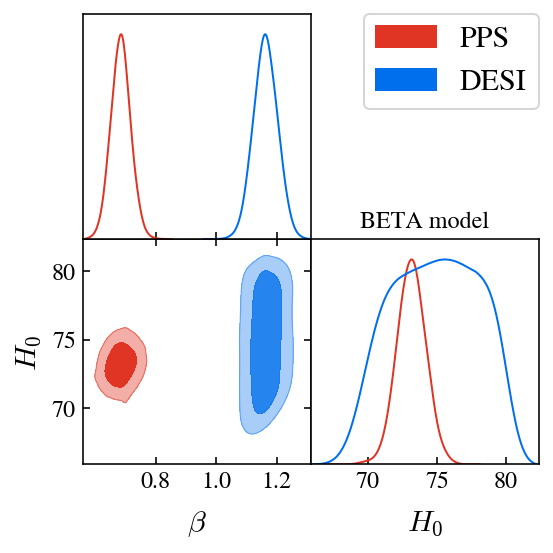

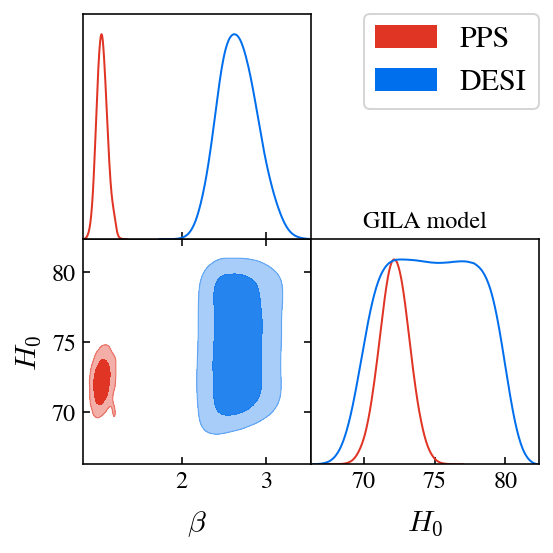

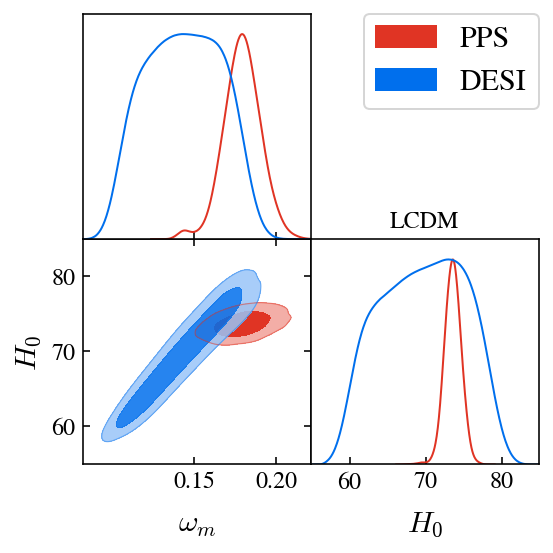

In [16]:
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples1_pps, samples1_desi],
				filled=True, params=names_GILA_1,
				#contour_colors=color,
				contour_lws=1,
				legend_labels=['PPS','DESI'])
plt.title('BETA model')
g.export(root_dic + 'triangle_plot_desi_beta_{}.pdf'.format(L_bar))

g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples2_pps, samples2_desi],
				filled=True, params=names_GILA_1,
				#contour_colors=color,
				contour_lws=1,
				legend_labels=['PPS','DESI'])
plt.title('GILA model')
g.export(root_dic + 'triangle_plot_desi_gila_{}.pdf'.format(L_bar))


g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples3_pps, samples3_desi],
				filled=True, params=names_LCDM_1,
				#contour_colors=color,
                title='LCDM',
				contour_lws=1,
				legend_labels=['PPS','DESI'])
plt.title('LCDM')
g.export(root_dic + 'triangle_plot_desi_lcdm_{}.pdf'.format(L_bar))

In [ ]:
def report_intervals(sampler, labels, discard=0, thin=1):
    if isinstance(sampler, np.ndarray)==True: #Posprocessed chains
        samples = sampler
        len_chain, ndim=samples.shape
    else:
        samples = sampler.get_chain(discard=discard, flat=True, thin=thin)
        len_chain, nwalkers, ndim = sampler.get_chain().shape

    #textfile_witness = open(save_path + '/intervals.dat','w')
    labels = labels
    for i in range(ndim):
        mean = np.mean(samples[:,i])
        one_s = 68
        two_s = 95

        one_sigma = az.hdi(samples,hdi_prob = one_s/100)[i]
        two_sigma = az.hdi(samples,hdi_prob = two_s/100)[i]

        q1 = np.diff([one_sigma[0],mean,one_sigma[1]])
        q2 = np.diff([two_sigma[0],mean,two_sigma[1]])

        if np.abs(one_sigma[0]) < 10**(-2): #Upper limit interval
            txt = "\mathrm{{{0}}} < {1:.3f}({2:.3f})"
            txt = txt.format(labels[i], mean + q1[1], mean + q2[1])

        else:
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}({4:.3f})}}^{{+{2:.3f}({5:.3f})}}"
            txt = txt.format(mean, q1[0], q1[1], labels[i], q2[0], q2[1])
        #textfile_witness.write('{} \n'.format(txt))
        print(txt)

In [ ]:
from IPython.display import display, Math
import arviz as az
from scipy.stats import scoreatpercentile
from getdist import plots, MCSamples

#LCDM intervals
print('LCDM model intervals:')
report_intervals(chains_lcdm, names_LCDM)
print('\n')

#BETA intervals
print('Beta model intervals:')
report_intervals(chains_beta, names_GILA)
print('\n')

#GILA intervals
print('GILA model intervals:')
report_intervals(chains_gila, names_GILA)


In [ ]:
a = 0.8
#a = 0.99
#a = 1
#a= 1.1
a = 0.002
#a = 15

import numpy as np 
from matplotlib import pyplot as plt
phis = np.linspace(-np.pi/2,np.pi/2,1000)

plt.plot(phis, np.cos(phis)+np.sqrt(a**2  - np.sin(phis)**2))
plt.plot(phis, np.cos(phis)-np.sqrt(a**2  - np.sin(phis)**2))
plt.hlines(0,np.min(phis),np.max(phis))
plt.grid()